In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Objective
Calculate the self-diffusion coefficient of TIP3P water from a molecular dynamics simulation.  
The reference value is $5.19 \times 10^{-5} cm^2/s$. See below for source.

#### Calculation parameters:
Data files and example input files in Github repo. Basic details:
- 1001 water molecules
- 30x30x30 Angstrom box (estimated, didn't check)
- 2 fs/time step
- data is taken every 0.1 ps (every 50 steps = every 100 fs)
- Temperature of 308 K


## Theory
This notebook makes use of the Green-Kubo relation, such as derived [here][1] to Eqn. 162.
- Components of x, y, z are added after integration
- Remember the factor of 3 after summing components


This code can be extended or repurposed for calculating diffusivity in an inhomogeneous system, such as a lipid bilayer (such as eq 4 [here][3]).

## Units
- Use the conversion factor for velocities from NAMD binary file [details][4]. This goes from internal units to  Angstroms/picosecond.
- Normalized autocorrelations don't have units. They're divided out as part of the normalization process. 
- Non-normalized autocorrelations have the original data's units squared.

## Reference data
From the web, literature, etc.
1. [Table of self-diffusion coefficients based on water model][5]
2. [Correlation function as a function of time][6] (I think this was normalized)
3. [Bit of background stat mech in these slides][7] (though the scale of VACF and diffusion coefficient is different, maybe they had a diff. setup)
4. In this [paper][8], fig 3 has clear plots and shows importance of small (< 1 ps) time step for recording data
5. Autocorrelation function:
    1. Equation in Leach for [velocity autocorrelation function][2].
    2. Good way of [visualizing][9] how the time correlation function works (also good background material in rest of slides)
6. If setting up new system for testing, remember to [consider the water density][10].
7. [Water's self-di†usion coefficient as a function of temperature][11]
8. Other work on TIP3P: [1][12]

## TODO
Parallelize the calcACF
- time before
- time after

Resources: [here](https://stackoverflow.com/questions/42550529/dask-how-would-i-parallelize-my-code-with-dask-delayed?rq=1) and [here](http://dask.pydata.org/en/latest/delayed-overview.html)


[1]: http://www.pages.drexel.edu/~cfa22/msim/node29.html
[2]: http://archive.ambermd.org/201305/att-0347/autocorrelation.jpg
[3]: http://pubs.acs.org/doi/full/10.1021/acs.jctc.6b00747
[4]: http://www.ks.uiuc.edu/Research/namd/mailing_list/namd-l.2008-2009/0435.html 
[5]: http://www1.lsbu.ac.uk/water/water_models.html
[6]: http://www.chem.pku.edu.cn/liujian/tutorial-lscivr/tutorial-lscivr.html#351-diffusion-constant
[7]: http://www.ks.uiuc.edu/Training/SumSchool/materials/lectures/6-3-Statistical-Mechanics-Proteins/1-ik_diffusion.pdf
[8]: https://istina.msu.ru/media/publications/articles/304/d61/3161642/water_en_2012.pdf
[9]: http://www.eng.buffalo.edu/~kofke/ce530/Lectures/Lecture12/sld012.htm
[10]: http://www.ks.uiuc.edu/Research/namd/mailing_list/namd-l.2003-2004/0911.html
[11]: http://pubs.rsc.org/en/content/articlepdf/2000/cp/b005319h
[12]: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3193570/

In [2]:
def readXYZnamd(infile):
    """
    Read in a pre-processed XYZ file from NAMD. 
    
    This was obtained from the NAMD binary file using the catdcd utility:
      'catdcd -s waterbox.psf -stype psf -i solu.index -o vels_0.xyz -otype xyz usWat-1.veldcd'
      Here, usWat-1.veldcd is the name of the binary file, and 
      solu.index is a plain ASCII file with 0 1 2 each on a new line bc those are the indices
      of the OH2, H1, H2 atoms of my specific water molecule.
      See more: http://www.ks.uiuc.edu/Development/MDTools/catdcd/
    The file was processed to remove all lines that didn't have velocity data.
    
    Parameter
    ---------
    infile: string name of pre-processed XYZ file 
    
    Returns
    -------
    vel*: numpy arrays of the 1st, 2nd, and 3rd columns in the file
    """
    velx, vely, velz = np.loadtxt(infile, usecols=(1,2,3), dtype=float, unpack=True)

    # internal namd units  --[* 20.45482706] --> Angstroms/picosecond
    # Angstroms/picosecond --[* 100.0]       --> m/s
    velx, vely, velz = 20.45482706*velx, 20.45482706*vely, 20.45482706*velz
    
    return velx, vely, velz

In [3]:
def calcCOM(inlist):
    """
    Calculate center of mass of the given timeseries.
       x_CM = (m1*x1 + m2*x2 + m3*x3) / (m1 + m2 + m3)

    Parameter
    ---------
    inlist: list of tuples, where each tuple is (weight, listData)
             ex., [(atomMass1, list1), (atomMass2, list2)]

    Returns
    -------
    final: list of center of mass of all the tuple list components

    """
    weighted = []
    denom = []
    for i in inlist:
        denom.append(i[0])
        weighted.append(i[0]*i[1])
    numerator = np.sum(weighted, axis=0)
    denominator = np.sum(denom)
    final = numerator / denominator
    return final

In [4]:
def calcACF(series, norm=True):
    """
    Calculate the autocorrelation function of the given timeseries.
    Modified code from David Wych.
       Cz(t) = 1/nSamples sum[ deltaZ(i) * deltaZ(i+t), {i=0, imax=nSamples} ]
       deltaZ(i) = z(i) - avgZ
    
    Parameters
    ----------
    series: numpy list of data from which to calculate the autocorrelation function
    norm: Boolean variable, whether to normalize output or not
    
    Returns
    -------
    C*: list containing the autocorrelation function
    
    
    """
    # assign cutoff from half of timeseries data
    N = len(series)
    cutoff = int(N/2)
    avg = np.average(series)
    
    # calculate ACF here
    lt = 1
    C_prime = []
    while lt <= cutoff:
        temp = []
        nSamples = N-lt
        for i in range(nSamples):
            temp.append((series[i]-avg)*(series[i+lt]-avg))
        term = np.sum(temp)/nSamples
        C_prime.append(term)
        lt += 1

    if not norm:
        return C_prime

    # normalization: since working with dZs, use norm of dZ vector
    # each i value will have diff normalization constant
    norms = []
    for i in range(N):
         norms.append((series[i]-avg)**2)
    norms = np.sum(norms)/N # take average
    C = C_prime/norms
    return C

In [5]:
def integrate(indata, dx=1):
    """
    Integrate the given function (in the form of a list) using the trapezoid rule.
       g(x) = int[ f(x), 0, t ] = sum[ dx/2 * (f_n + f_(n+1)), {n=0, n=N-1} ]
    List is traversed in reverse to set baseline at zero.
    Each increment here is 0.1 ps
    
    Parameters
    ----------
    indata: list of function to be integrated, assumes equal spacing of dx
    dx: spacing of data. keep units consistent. if normalized, use 1?
    
    Returns
    -------
    scaled[0] : first item of the numpy array which is the final integrated value
    """
    
    integ = np.zeros([len(indata)], np.float64)
    last = 0
    i = len(indata)-1 # this -1 is bc of 0-index
    while i > 0:
        #print(i, last, indata[i], indata[i-1])
        last = integ[i-1] = 0.5*(indata[i]+indata[i-1])+last
        i -= 1

    scaled = dx*integ
    return scaled[0]

In [6]:
def integrate_2(indata, dx=1):
    """
    Integrate the given function (in the form of a list) using the trapezoid rule.
       g(x) = int[ f(x), 0, t ] = sum[ dx/2 * (f_n + f_(n+1)), {n=0, n=N-1} ]
    List is traversed in reverse to set baseline at zero.
    Each increment here is 0.1 ps
    
    Parameters
    ----------
    indata: list of function to be integrated, assumes equal spacing of dx
    dx: spacing of data. keep units consistent. if normalized, use 1?
    
    Returns
    -------
    scaled[0] : first item of the numpy array which is the final integrated value
    """
    
    integ = np.zeros([len(indata)], np.float64)
    last = indata[0]
    
    for i in range(len(indata)-1):
        last = integ[i] = 0.5*(indata[i]+indata[i+1])+last

    scaled = dx*integ
    return scaled[0]

In [7]:
# Load data
velx_0, vely_0, velz_0 = readXYZnamd('run2/vels_0.xyz')
velx_1, vely_1, velz_1 = readXYZnamd('run2/vels_1.xyz')
velx_2, vely_2, velz_2 = readXYZnamd('run2/vels_2.xyz')

Text(0,0.5,'$\\AA$/ps')

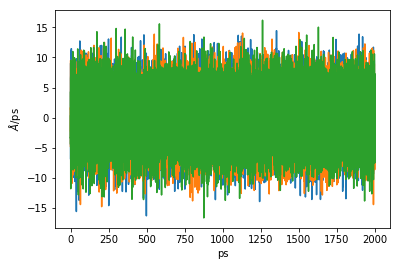

In [8]:
# Visualize velocity data
plt.plot(np.arange(len(velx_0))/10,velx_0)
plt.plot(np.arange(len(vely_0))/10,vely_0)
plt.plot(np.arange(len(velz_0))/10,velz_0)
plt.xlabel('ps')
plt.ylabel('$\AA$/ps')  # if dividing x-values by 10, use A/ps
#plt.ylabel('m/s')

In [9]:
# calculate center of mass of each component
velx_all = [(16., velx_0), (1.01, velx_1), (1.01, velx_2)]
velx_com = calcCOM(velx_all)

vely_all = [(16., vely_0), (1.01, vely_1), (1.01, vely_2)]
vely_com = calcCOM(vely_all)

velz_all = [(16., velz_0), (1.01, velz_1), (1.01, velz_2)]
velz_com = calcCOM(velz_all)

Text(0,0.5,'$\\AA$/ps')

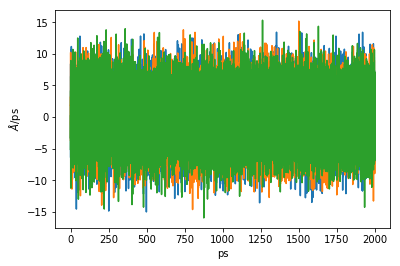

In [10]:
# visualize to make sure nothing went awry
# resulting plot should be much closer to O than to the 2 Hs
plt.plot(np.arange(len(velx_com))/10,velx_com)
plt.plot(np.arange(len(vely_com))/10,vely_com)
plt.plot(np.arange(len(velz_com))/10,velz_com)
plt.xlabel('ps')
plt.ylabel('$\AA$/ps') # if dividing x-values by 10, use A/ps
#plt.ylabel('m/s')

In [11]:
# calculate the autocorrelation function for each velocity component
acf_x = calcACF(velx_com, norm=False)
acf_y = calcACF(vely_com, norm=False)
acf_z = calcACF(velz_com, norm=False)

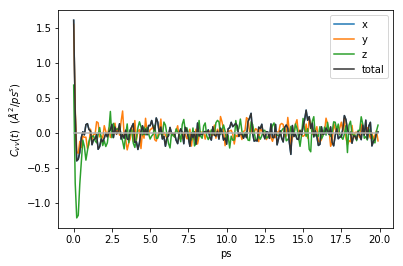

In [12]:
acf_sum = acf_x + acf_y + acf_z

# visualize the ACF
trim = 200
plt.plot(np.arange(len(acf_x[:trim]))/10,acf_x[:trim], label='x')
plt.plot(np.arange(len(acf_y[:trim]))/10,acf_y[:trim], label='y')
plt.plot(np.arange(len(acf_z[:trim]))/10,acf_z[:trim], label='z')
plt.plot(np.arange(len(acf_sum[:trim]))/10,acf_sum[:trim], label='total', c='0.2')
plt.plot(np.arange(len(acf_z[:trim]))/10,np.zeros(len(acf_z[:trim])), c='0.7')
plt.xlabel('ps')
plt.ylabel('$C_{vv}(t) \ \ (\AA^2/ps^s)$')
plt.legend()

In [13]:
diffx, diffy, diffz = integrate(acf_x, dx=0.1), integrate(acf_y, dx=0.1), integrate(acf_z, dx=0.1)

In [14]:
print(diffx, diffy, diffz)
diff_tot = sum([diffx, diffy, diffz])/3 # A2/ps
diff_tot_scaled = sum([diffx, diffy, diffz])/3*1e-8 # m2/s: (1e-20) A2 to m2, (1e12) 1/ps to 1/s
diff_tot_scaled

-0.179200159182 -0.487524271259 -0.896965871104


-5.2123010051487541e-09

In [15]:
diffx, diffy, diffz = integrate_2(acf_x, dx=0.1), integrate_2(acf_y, dx=0.1), integrate_2(acf_z, dx=0.1)

In [16]:
print(diffx, diffy, diffz)
diff_tot = sum([diffx, diffy, diffz])/3 # A2/ps
diff_tot_scaled = sum([diffx, diffy, diffz])/3*1e-8 # m2/s: (1e-20) A2 to m2, (1e12) 1/ps to 1/s
diff_tot_scaled

0.256217650083 0.249977707144 0.0668359663421


1.9101044118971741e-09

In [17]:
np.trapz(acf_x, dx=0.1), np.trapz(acf_y, dx=0.1), np.trapz(acf_z, dx=0.1)

(-0.17920015918170618, -0.48752427125935771, -0.89696587110356119)